In [42]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('fertilizer.csv')

In [43]:
df.rename(columns={'Temparature':'Temperature'}, inplace=True)

In [44]:
df.head()

,Temperature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name
0,26.0,52.0,38.0,Sandy,Maize,37,0,0,Urea
1,29.0,52.0,45.0,Loamy,Sugarcane,12,0,36,DAP
2,34.0,65.0,62.0,Black,Cotton,7,9,30,14-35-14
3,32.0,62.0,34.0,Red,Tobacco,22,0,20,28-28
4,28.0,54.0,46.0,Clayey,Paddy,35,0,0,Urea


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Temperature      8000 non-null   float64
 1   Humidity         8000 non-null   float64
 2   Moisture         8000 non-null   float64
 3   Soil Type        8000 non-null   object 
 4   Crop Type        8000 non-null   object 
 5   Nitrogen         8000 non-null   int64  
 6   Potassium        8000 non-null   int64  
 7   Phosphorous      8000 non-null   int64  
 8   Fertilizer Name  8000 non-null   object 
dtypes: float64(3), int64(3), object(3)
memory usage: 562.6+ KB


In [47]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

In [48]:
# Load the dataset
df = pd.read_csv('fertilizer.csv')

In [49]:
# Display basic information
print("Dataset shape:", df.shape)
print("\nFirst few rows:")
display(df.head())

Dataset shape: (8000, 9)

First few rows:


,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name
0,26.0,52.0,38.0,Sandy,Maize,37,0,0,Urea
1,29.0,52.0,45.0,Loamy,Sugarcane,12,0,36,DAP
2,34.0,65.0,62.0,Black,Cotton,7,9,30,14-35-14
3,32.0,62.0,34.0,Red,Tobacco,22,0,20,28-28
4,28.0,54.0,46.0,Clayey,Paddy,35,0,0,Urea


In [50]:
# Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())


Missing values in each column:
Temparature        0
Humidity           0
Moisture           0
Soil Type          0
Crop Type          0
Nitrogen           0
Potassium          0
Phosphorous        0
Fertilizer Name    0
dtype: int64


In [51]:
# Check the distribution of Crop Type (our target variable)
print("\nCrop Type distribution:")
crop_counts = df['Crop Type'].value_counts()
print(crop_counts)


Crop Type distribution:
Crop Type
Sugarcane      763
Maize          753
Wheat          747
Ground Nuts    732
Pulses         728
Cotton         722
Millets        718
Tobacco        717
Oil seeds      711
Paddy          706
Barley         703
Name: count, dtype: int64


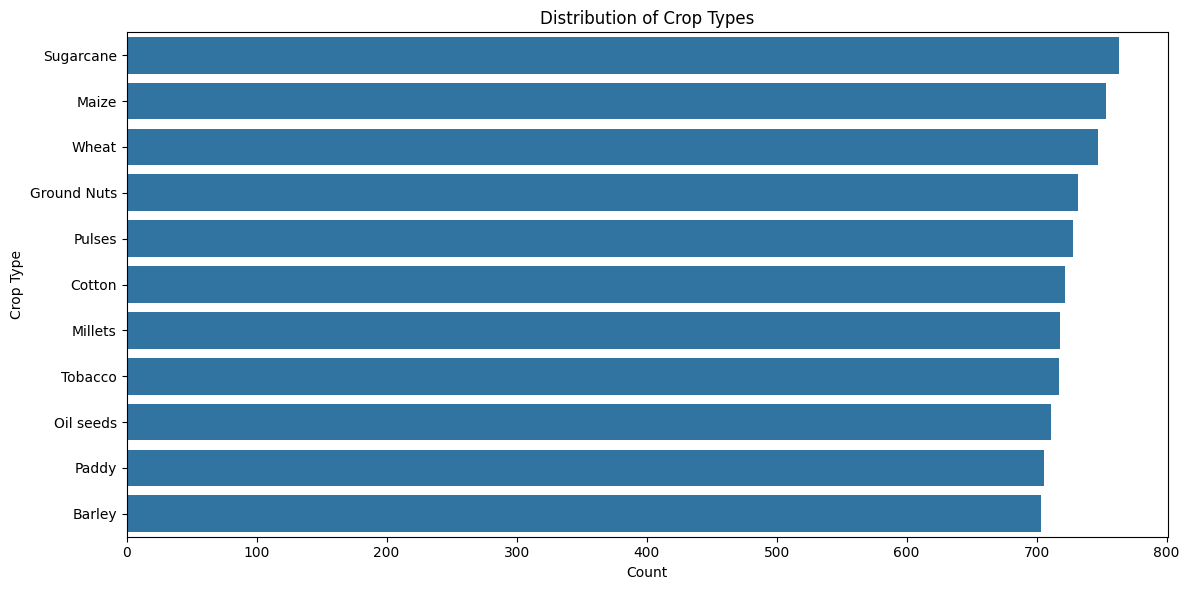

In [52]:
# Visualize crop type distribution
plt.figure(figsize=(12, 6))
sns.countplot(y=df['Crop Type'], order=df['Crop Type'].value_counts().index)
plt.title('Distribution of Crop Types')
plt.xlabel('Count')
plt.ylabel('Crop Type')
plt.tight_layout()
plt.show()


In [53]:
# Prepare data: features and target
# Drop 'Fertilizer Name' as we're predicting crop type based on soil parameters
X = df.drop(['Crop Type', 'Fertilizer Name'], axis=1)
y = df['Crop Type']

In [54]:
# Create useful feature interactions
X['N_P_ratio'] = X['Nitrogen'] / (X['Phosphorous'] + 0.1)  # Adding 0.1 to avoid division by zero
X['N_K_ratio'] = X['Nitrogen'] / (X['Potassium'] + 0.1)
X['P_K_ratio'] = X['Phosphorous'] / (X['Potassium'] + 0.1)
X['NPK_sum'] = X['Nitrogen'] + X['Phosphorous'] + X['Potassium']
X['Temp_Humid_ratio'] = X['Temparature'] / (X['Humidity'] + 0.1)
X['Temp_Moisture_ratio'] = X['Temparature'] / (X['Moisture'] + 0.1)

In [55]:
# One-hot encode categorical features
X = pd.get_dummies(X, columns=['Soil Type'], drop_first=False)

In [56]:
X.head()

,Temparature,Humidity,Moisture,Nitrogen,Potassium,Phosphorous,N_P_ratio,N_K_ratio,P_K_ratio,NPK_sum,Temp_Humid_ratio,Temp_Moisture_ratio,Soil Type_Black,Soil Type_Clayey,Soil Type_Loamy,Soil Type_Red,Soil Type_Sandy
0,26.0,52.0,38.0,37,0,0,370.000000,370.000000,0.000000,37,0.499040,0.682415,False,False,False,False,True
1,29.0,52.0,45.0,12,0,36,0.332410,120.000000,360.000000,48,0.556622,0.643016,False,False,True,False,False
2,34.0,65.0,62.0,7,9,30,0.232558,0.769231,3.296703,46,0.522273,0.547504,True,False,False,False,False
3,32.0,62.0,34.0,22,0,20,1.094527,220.000000,200.000000,42,0.515298,0.938416,False,False,False,True,False
4,28.0,54.0,46.0,35,0,0,350.000000,350.000000,0.000000,35,0.517560,0.607375,False,True,False,False,False


In [57]:
soil_columns = [col for col in X.columns if "Soil Type_" in col]
X[soil_columns] = X[soil_columns].astype(int)

In [58]:
X.head()

,Temparature,Humidity,Moisture,Nitrogen,Potassium,Phosphorous,N_P_ratio,N_K_ratio,P_K_ratio,NPK_sum,Temp_Humid_ratio,Temp_Moisture_ratio,Soil Type_Black,Soil Type_Clayey,Soil Type_Loamy,Soil Type_Red,Soil Type_Sandy
0,26.0,52.0,38.0,37,0,0,370.000000,370.000000,0.000000,37,0.499040,0.682415,0,0,0,0,1
1,29.0,52.0,45.0,12,0,36,0.332410,120.000000,360.000000,48,0.556622,0.643016,0,0,1,0,0
2,34.0,65.0,62.0,7,9,30,0.232558,0.769231,3.296703,46,0.522273,0.547504,1,0,0,0,0
3,32.0,62.0,34.0,22,0,20,1.094527,220.000000,200.000000,42,0.515298,0.938416,0,0,0,1,0
4,28.0,54.0,46.0,35,0,0,350.000000,350.000000,0.000000,35,0.517560,0.607375,0,1,0,0,0


In [59]:
# Encode the target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)
print("\nEncoded crop classes:")
for i, crop in enumerate(le.classes_):
    print(f"{i}: {crop}")



Encoded crop classes:
0: Barley
1: Cotton
2: Ground Nuts
3: Maize
4: Millets
5: Oil seeds
6: Paddy
7: Pulses
8: Sugarcane
9: Tobacco
10: Wheat


In [60]:
df.head()

,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name
0,26.0,52.0,38.0,Sandy,Maize,37,0,0,Urea
1,29.0,52.0,45.0,Loamy,Sugarcane,12,0,36,DAP
2,34.0,65.0,62.0,Black,Cotton,7,9,30,14-35-14
3,32.0,62.0,34.0,Red,Tobacco,22,0,20,28-28
4,28.0,54.0,46.0,Clayey,Paddy,35,0,0,Urea


In [61]:
# Split the data with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

In [62]:
print(f"\nTraining set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")


Training set shape: (6400, 17)
Test set shape: (1600, 17)


In [63]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [64]:
# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)


In [65]:
print(f"\nOriginal training set shape: {X_train.shape}")
print(f"Resampled training set shape: {X_train_resampled.shape}")


Original training set shape: (6400, 17)
Resampled training set shape: (6710, 17)


In [66]:
# Train Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=2,
    min_samples_leaf=2,
    class_weight='balanced',
    criterion='entropy',
    random_state=42,
    n_jobs=-1
)


In [67]:
rf_model.fit(X_train_resampled, y_train_resampled)
y_pred_rf = rf_model.predict(X_test_scaled)
rf_accuracy = accuracy_score(y_test, y_pred_rf)
print(f"\nRandom Forest Accuracy: {rf_accuracy:.4f}")


Random Forest Accuracy: 0.0931


In [68]:
# Train Gradient Boosting model
gb_model = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

In [69]:
gb_model.fit(X_train_resampled, y_train_resampled)
y_pred_gb = gb_model.predict(X_test_scaled)
gb_accuracy = accuracy_score(y_test, y_pred_gb)
print(f"Gradient Boosting Accuracy: {gb_accuracy:.4f}")

Gradient Boosting Accuracy: 0.0906


In [70]:
# Choose the better model
better_model = gb_model if gb_accuracy > rf_accuracy else rf_model
better_pred = y_pred_gb if gb_accuracy > rf_accuracy else y_pred_rf
better_name = "Gradient Boosting" if gb_accuracy > rf_accuracy else "Random Forest"

print(f"\nDetailed Classification Report for {better_name}:")
print(classification_report(y_test, better_pred, target_names=le.classes_))



Detailed Classification Report for Random Forest:
              precision    recall  f1-score   support

      Barley       0.09      0.09      0.09       141
      Cotton       0.07      0.08      0.07       144
 Ground Nuts       0.08      0.09      0.09       146
       Maize       0.11      0.11      0.11       151
     Millets       0.10      0.10      0.10       144
   Oil seeds       0.11      0.10      0.11       142
       Paddy       0.09      0.11      0.10       141
      Pulses       0.14      0.14      0.14       146
   Sugarcane       0.07      0.07      0.07       153
     Tobacco       0.08      0.08      0.08       143
       Wheat       0.06      0.06      0.06       149

    accuracy                           0.09      1600
   macro avg       0.09      0.09      0.09      1600
weighted avg       0.09      0.09      0.09      1600



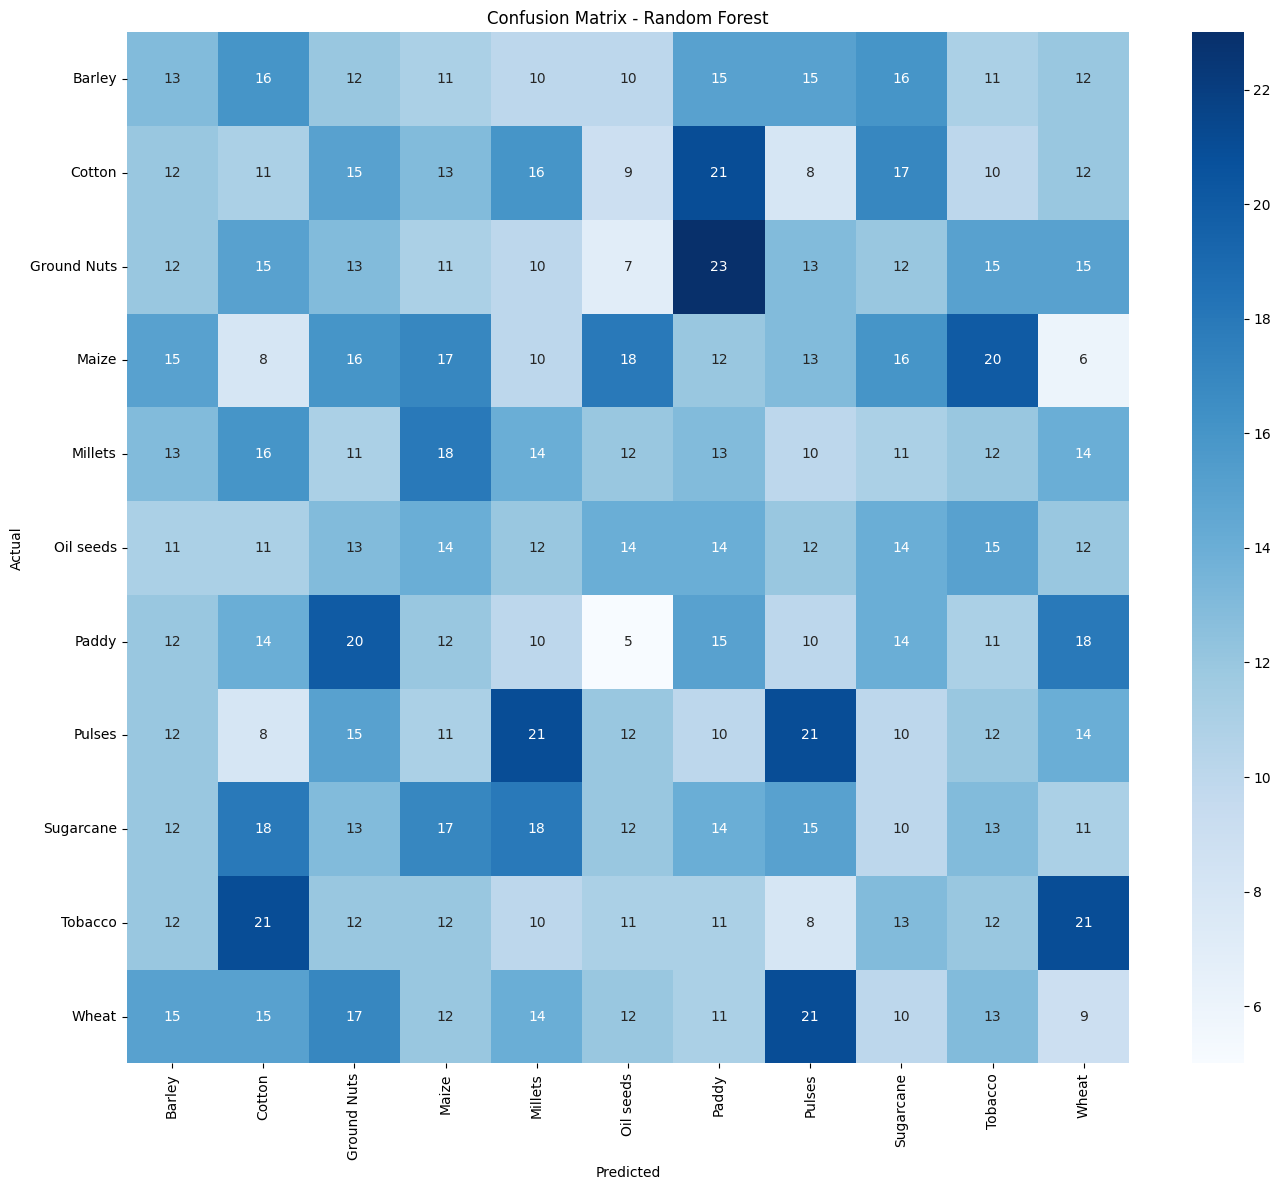

In [71]:
# Confusion matrix visualization
plt.figure(figsize=(14, 12))
cm = confusion_matrix(y_test, better_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - {better_name}')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

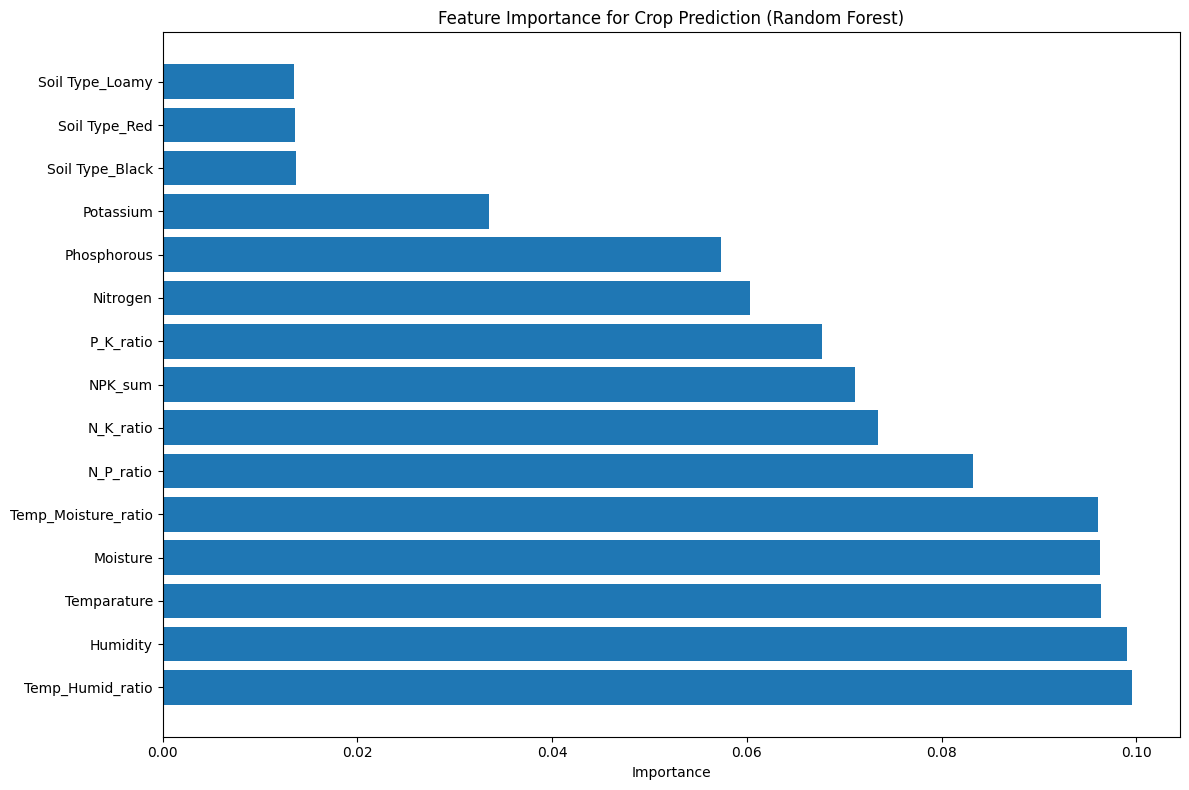

In [72]:
# Feature importance analysis
feature_importance = better_model.feature_importances_
sorted_idx = np.argsort(feature_importance)[::-1]
sorted_features = np.array(X.columns)[sorted_idx]

plt.figure(figsize=(12, 8))
plt.title(f'Feature Importance for Crop Prediction ({better_name})')
plt.barh(range(15), feature_importance[sorted_idx[:15]], align='center')
plt.yticks(range(15), sorted_features[:15])
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

In [74]:
# Hyperparameter tuning with cross-validation for the better model
if better_name == "Random Forest":
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [15, 20, 25, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2, 4]
    }
    model_to_tune = RandomForestClassifier(class_weight='balanced', criterion='entropy', random_state=42)
else:
    param_grid = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.05, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    }
    model_to_tune = GradientBoostingClassifier(random_state=42)

print(f"\nPerforming hyperparameter tuning for {better_name}...")
grid_search = GridSearchCV(
    model_to_tune, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1
)
grid_search.fit(X_train_resampled, y_train_resampled)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")


Performing hyperparameter tuning for Random Forest...
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameters: {'max_depth': 25, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation score: 0.1532


In [75]:
# Test the best model
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test_scaled)
best_accuracy = accuracy_score(y_test, y_pred_best)
print(f"\nBest {better_name} Model Accuracy: {best_accuracy:.4f}")

# Final classification report with the best model
print("\nFinal Classification Report with the Best Model:")
print(classification_report(y_test, y_pred_best, target_names=le.classes_))


Best Random Forest Model Accuracy: 0.0919

Final Classification Report with the Best Model:
              precision    recall  f1-score   support

      Barley       0.09      0.09      0.09       141
      Cotton       0.07      0.07      0.07       144
 Ground Nuts       0.09      0.10      0.09       146
       Maize       0.11      0.12      0.11       151
     Millets       0.10      0.09      0.10       144
   Oil seeds       0.10      0.07      0.08       142
       Paddy       0.10      0.12      0.11       141
      Pulses       0.10      0.10      0.10       146
   Sugarcane       0.08      0.08      0.08       153
     Tobacco       0.09      0.09      0.09       143
       Wheat       0.07      0.08      0.08       149

    accuracy                           0.09      1600
   macro avg       0.09      0.09      0.09      1600
weighted avg       0.09      0.09      0.09      1600

